# Monet using GAN

In [53]:
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import ops
# import tensorflow_addons as tfa
# from kaggle_datasets import KaggleDatasets


datapath = r'C:\Users\kuusnin\tempwork\temp\gan-getting-started'
if not os.path.exists(r'C:\Users\kuusnin\tempwork\temp\gan-getting-started'):
    datapath = r'C:\Users\nikok\Documents\Monet using GAN'



### Set up TPU

In [56]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

Number of replicas: 1
2.19.0


## Brief description of the problem and data (5 pts)

*Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.*

In [2]:
monet_files = os.listdir(os.path.join(datapath, 'monet_tfrec'))
photo_files = os.listdir(os.path.join(datapath, 'photo_tfrec'))
monet_filenames = [os.path.join(datapath, 'monet_tfrec', f) for f in monet_files]
photo_filenames = [os.path.join(datapath, 'photo_tfrec', f) for f in photo_files]
print(20*'*', 'Monet paintings', 20*'*')
print('First filename:', monet_files[0], '\nNumber of files:', len(monet_files))
print(20*'*', 'Photos', 20*'*')
print('First filename:', photo_files[0], '\nNumber of files:', len(photo_files))

******************** Monet paintings ********************
First filename: monet00-60.tfrec 
Number of files: 5
******************** Photos ********************
First filename: photo00-352.tfrec 
Number of files: 20


### Figure out the contents of the tfrec files

From the code below we can see that each record/example contains three fields: 
* target: label of the image. Not needed in this work 
* image_name: name of the image
* image: the actual image data

Both of the data sets appear to have the same structure. 

In [3]:
# The following code is adapted from an answer from Microsoft Copilot
import tensorflow as tf
from google.protobuf.json_format import MessageToJson
import json

def iterate_record(dataset):
    # Initialize a counter
    record_count = 0
    # Iterate through the dataset and count the records
    for _ in dataset:
        record_count += 1
    print(f'Total number of records: {record_count}')
    
    # Iterate through the dataset and parse each record
    for raw_record in dataset.take(1):  # Adjust the number to read more records
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        json_message = MessageToJson(example)
        parsed_record = json.loads(json_message)
        print(json.dumps(parsed_record, indent=2))

# Create a TFRecordDataset
print(20*'*', 'Monet paintings', 20*'*')
raw_monet_dataset = tf.data.TFRecordDataset(monet_filenames)
iterate_record(raw_monet_dataset)

print(20*'*', 'Photos', 20*'*')
raw_photo_dataset = tf.data.TFRecordDataset(photo_filenames)
iterate_record(raw_photo_dataset)


******************** Monet paintings ********************
Total number of records: 300
{
  "features": {
    "feature": {
      "target": {
        "bytesList": {
          "value": [
            "bW9uZXQ="
          ]
        }
      },
      "image_name": {
        "bytesList": {
          "value": [
            "MjVjOTkwNDc4Mg=="
          ]
        }
      },
      "image": {
        "bytesList": {
          "value": [
            "/9j/4AAQSkZJRgABAQEBLAEsAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAEAAQADAREAAhEBAxEB/8QAHgAAAgIDAQEBAQAAAAAAAAAABgcEBQMICQIACgH/xABLEAACAQIEAwUFBAkDAQcBCQADBAUGEwACByMUM0MIEhVTYwEiJHODFjI0kwkXJUSjs8PT8BFC4/MhJjVFUlRkGAoxUVVicnS01P/EABsBAAIDAQEBAAAAAAAAAAAAAAQFAgMGAAcB/8QAPhEAAQMCBQIEAwYEBQQDAQAAAwAEEwIFEhQiIzMGQxUkMlNCY3MBg5Ojs/AHUsPTFiU0YuMRRHLzFyExNf/aAAwDAQACEQMRAD8As9GIGH0+p+nqbpKBAThxXxLMiJbGS3c6ePFw

We can parse the data now since the structure of the tfrecord is known.

In [4]:
def parse_tfrecord_fn(example):
    feature_description = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    return example

monet_dataset = raw_monet_dataset.map(parse_tfrecord_fn)
photo_dataset = raw_photo_dataset.map(parse_tfrecord_fn)



## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

*Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?*

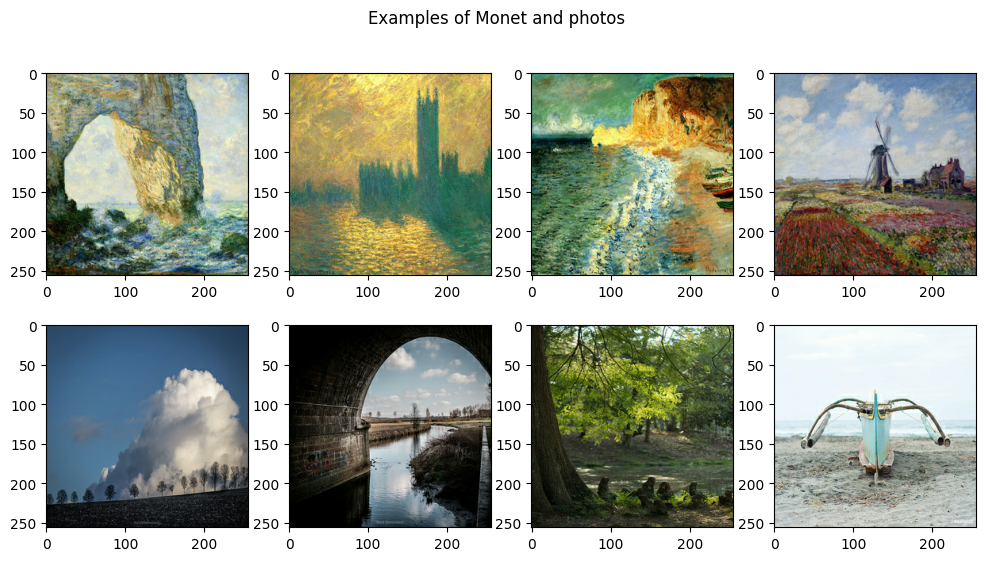

In [5]:
fig = plt.figure(figsize=(12, 6))
i = 0
for data in monet_dataset.take(4):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(data['image'].numpy())
    i += 1
for data in photo_dataset.take(4):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(data['image'].numpy())
    i += 1
fig.suptitle('Examples of Monet and photos')
plt.show()

In [6]:
dims = []
for data in photo_dataset:
    img = data['image'].numpy().shape
    dims.append(img)
print('Unique shapes of the photos data:', set(dims))

dims = []
for data in monet_dataset:
    dims.append(data['image'].numpy().shape)
print('Unique shapes of the Monet data:', set(dims))

Unique shapes of the photos data: {(256, 256, 3)}
Unique shapes of the Monet data: {(256, 256, 3)}


In [16]:
my_image_shape = (256, 256, 3)

In [7]:
def plot_histogram(dataset, title):
    rgb = []
    for data in dataset:
        rgb.append(data['image'].numpy())
    rgb = np.array(rgb)
    # rgb.shape
    pic_channels = ['red', 'green', 'blue']
    rgb_df = pd.DataFrame()
    for i, clr in enumerate(pic_channels):
        df = pd.DataFrame(rgb[:,:,:,i].ravel(), columns=['val'])
        df['color'] = clr
        rgb_df = pd.concat([rgb_df, df])
    print('Minimum and maximmum values in ' + title + ' data: ', min(rgb_df.val), '&', max(rgb_df.val))
    sns.histplot(rgb_df.sample(1000), x='val', hue='color', bins=30, multiple='dodge', color=['green', 'blue', 'red'])
    plt.grid()
    plt.title('Histogram of ' + title)
    plt.show()
    

Minimum and maximmum values in sample photos data:  0 & 255


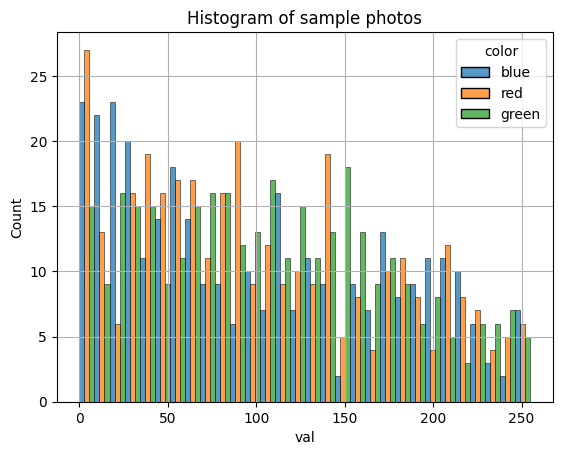

Minimum and maximmum values in Monet paintings data:  0 & 255


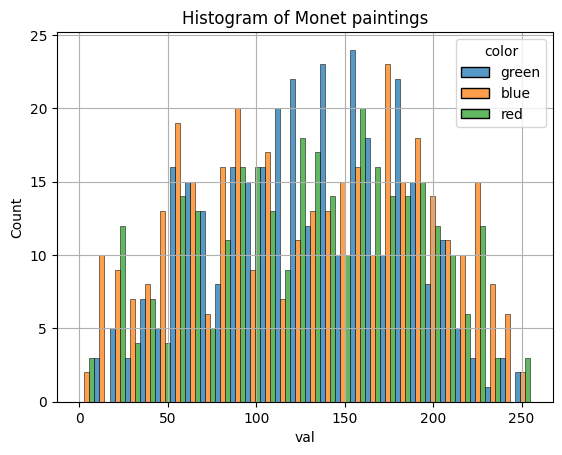

In [8]:
plot_histogram(photo_dataset.take(300), title='sample photos')
plot_histogram(monet_dataset, title='Monet paintings')


## Model Architecture (25 pts)

*Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.*

*Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.*

*There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.*

*Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.).*

### Discriminator

In [17]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=my_image_shape),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,681 (2.01 MB)

 Trainable params: 527,681 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

Test the untrained discriminator

In [47]:
for test_image in photo_dataset.take(1):
    decision = discriminator(np.expand_dims(test_image['image'], axis=0))
    print(decision)

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


### Generator

In [51]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=4, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=4, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

# tf.keras.utils.plot_model(generator, show_shapes = True, show_layer_names = True)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_18             │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_19             │ (None, 64, 64, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_20             │ (None, 256, 256, 512)  │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 256, 256, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 3)    │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

Test the untrained generator by generating a random image

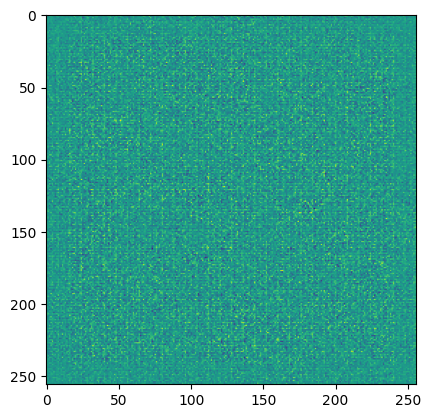

In [39]:
noise = tf.random.normal([1, 128])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0,:,:,0])

### Override train step

In [34]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        print(real_images['image'])
        batch_size = ops.shape(real_images['image'])[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        print(generated_images.shape)
        print(real_images['image'].shape)
        combined_images = ops.concatenate([generated_images, real_images['image']], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


### Callback


In [28]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))


### Training

In [35]:
epochs = 1  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    photo_dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Tensor("data:0", shape=(None, None, 3), dtype=uint8)
(None, 256, 256, 3)
(None, None, 3)


ValueError: Shape must be rank 4 but is rank 3 for '{{node concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](generator_1/conv2d_10_1/Sigmoid, Cast_2, concat/axis)' with input shapes: [?,256,256,3], [?,?,3], [].

## Alternative

https://www.kaggle.com/code/clementdelteil/dcgan-architectures-on-monet-s-paintings

In [65]:
with strategy.scope():
    def discriminator_loss(predictions_real, predictions_gen, labels_real):
        return (tf.reduce_mean((predictions_gen  - tf.reduce_mean(predictions_real) + labels_real) ** 2) +
                tf.reduce_mean((predictions_real - tf.reduce_mean(predictions_gen)  - labels_real) ** 2))/2
    
    def generator_loss(predictions_real, predictions_gen, labels_real):
        return (tf.reduce_mean((predictions_real - tf.reduce_mean(predictions_gen)  + labels_real) ** 2) +
                tf.reduce_mean((predictions_gen  - tf.reduce_mean(predictions_real) - labels_real) ** 2)) / 2

In [58]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [59]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [60]:
# Set the hyperparameters to be used for training
EPOCHS = 500
BATCH_SIZE = 32
noise_dim = 100
shape_dim = [256,256,3]
examples_to_generate = 25
seed = tf.random.normal([examples_to_generate, noise_dim])


In [62]:
generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.9, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.9, beta_2=0.999)

In [69]:
class DCGAN_model:
    def __init__(self, noise_dim, seed, EPOCHS, BATCH_SIZE, generator, discriminator, dataset, num_model):  
        self.noise_dim = noise_dim
        self.EPOCHS = EPOCHS
        self.BATCH_SIZE = BATCH_SIZE
        
        self.generator = generator
        #self.discriminator = discriminator2
        self.dataset = dataset
        self.num = num_model
        self.seed = seed
    
    @tf.function
    def train(self, images):
    
    # Create random noise vector
        noise = tf.random.normal([images['image'].shape[0], noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # generate images use random noise vector
            generated_images = self.generator(noise, training=True)

            # use discriminator to evaluate the real and fake images
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            # compute generator loss and discriminator loss
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

            # Compute gradients
            gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            # Update optimizers
            generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        return (gen_loss + disc_loss) * 0.5
    
    @tf.function
    def distributed_train(self, images):
        per_replica_losses = strategy.run(self.train, args=(images,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)
    
    def generate_images(self):
        predictions = self.generator.predict(self.seed)
        return predictions
        
    def save_images(self, directory, epoch, images):
        gen_imgs = 0.5 * images + 0.5

        fig = plt.figure(figsize=(5, 5))

        for i in range(25):
            plt.subplot(5, 5, i+1)
            plt.imshow(gen_imgs[i, :, :, :])
            plt.axis('off')

        plt.savefig(os.path.join(directory, 'image_at_epoch_{:04d}.png'.format(epoch)))
        plt.close()
            
    def plot_images(self, images):      
        gen_imgs = 0.5 * images + 0.5
        
        fig = plt.figure(figsize=(10, 10))
        for i in range(25):
            plt.subplot(5, 5, i+1)
            plt.imshow(gen_imgs[i, :, :, :])
            plt.axis('off')
        plt.show()

    def save_single_image(filename, generated_image, epoch):
        img = keras.utils.array_to_img(generated_image)
        img.save(filename)

    def train_loop(self):
        e_ls = []
        mean_ls = []
        
        for epoch in range(self.EPOCHS):
            start = time.time()

            total_loss = 0.0
            num_batches = 0

            for image_batch in self.dataset:
                loss = self.distributed_train(image_batch)
                total_loss += tf.reduce_mean(loss)  # Compute the mean loss accross the tensors
                num_batches += 1
            
            mean_loss = total_loss / num_batches
            
            mean_ls.append(mean_loss)
            e_ls.append(epoch+1)
            
            images = self.generate_images()
            self.save_images('grid_' + self.num, epoch+1, images)
            self.save_single_image('single_' + self.num, images[0], epoch+1)

            if (epoch+1) % 20 == 0:                                  
                print ('Time for epoch {} is {} sec, mean loss is {}'.format(epoch + 1, time.time()-start, mean_loss))
                self.plot_images(images)
       
        table = pd.DataFrame({"Epoch": e_ls, "Mean Loss": np.array(mean_ls)})
        
        return table, e_ls, mean_ls

In [70]:
# train, visualize and print out the result for DCGAN model
gan1 = DCGAN_model(noise_dim, seed, EPOCHS, BATCH_SIZE, generator, discriminator, monet_dataset, '1')

In [71]:
table, ep_ls, mean_ls = gan1.train_loop()

ValueError: in user code:

    File "C:\Users\kuusnin\AppData\Local\Temp\ipykernel_28248\1288989694.py", line 44, in distributed_train  *
        per_replica_losses = strategy.run(self.train, args=(images,))
    File "C:\Users\kuusnin\AppData\Local\Temp\ipykernel_28248\618831921.py", line 22, in train  *
        generated_images = self.generator(noise, training=True)
    File "C:\Users\kuusnin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\kuusnin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling Sequential.call().
    
    [1mInput 0 of layer "dense_8" is incompatible with the layer: expected axis -1 of input shape to have value 128, but received input with shape (256, 100)[0m
    
    Arguments received by Sequential.call():
      • inputs=tf.Tensor(shape=(256, 100), dtype=float32)
      • training=True
      • mask=None


## Results and Analysis (35 pts)

*Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.*

*Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.*

## Conclusion (15 pts)

*Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?*

# Sources

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
